# Introduction

As you learned in lecture, any function can be approximated with a series of sines and cosines. This tutorial will give you the practical skills needed to apply the Fourier Transform and several common filters to time series data. In essence, this is a new set of tools you can add to your time series toolbox.

# Learning Outcomes
You should walk away from this tutorial with:
1. A basic understanding of the Fourier Transform (FT).
2. Knowledge of the most common filters and why they are useful.
3. The know-how to make forecasts using the Fourier Transform.

# Imports

In [1]:
# %matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
from scipy import signal

# Python & Library Versions

In [2]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("scipy", sc.__version__) )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)] 

library    version
------------------
matplotlib  3.1.0
numpy       1.16.4
pandas      0.24.2
scipy       1.2.1


---

# Section 1: Fourier Transform (FT)
The idea behind the Fourier Transform (FT) is that any time signal can be decomposed into a sum of sines that have different amplitude, frequencies, and phases.

Let's start by creating a simple data set that consists of a sine wave with a frequency of 1 Hz.

In [3]:
freq = 1

# Data set in Time Domain
time = np.linspace(0, 5, 512)
y_sine = np.sin(2 * np.pi * freq * time)

Below we have a function that creates both a time domain and frequency domain plot.

In [4]:
def plot_time_freq(t, y):
    # Converts Data into Frequncy Domain
    freq = np.fft.fftfreq(t.size,d = t[1]-t[0])
    Y = abs(np.fft.fft(y))
    
    # Time domain plot
    plt.figure(figsize = [15,5])
    plt.subplot(1,2,1)
    plt.plot(t,y)
    plt.title('Time Domain')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    
    # Frequency domain plot
    plt.subplot(1,2,2)
    plt.plot(np.fft.fftshift(freq),np.fft.fftshift(Y),'r')
    plt.title('Frequency Domain')
    plt.xlabel('Frequency')
    plt.xlim(-20, 20)
    plt.ylabel('Absolute FFT')
    plt.grid()

We will now plot the sine wave, and we can observe that in the frequency domain there are 2 spikes at +1Hz and -1Hz.  This indicates the frequency of the sine wave.  Note that there is a symmetry between the left and right side across the 0 Hz frequency.

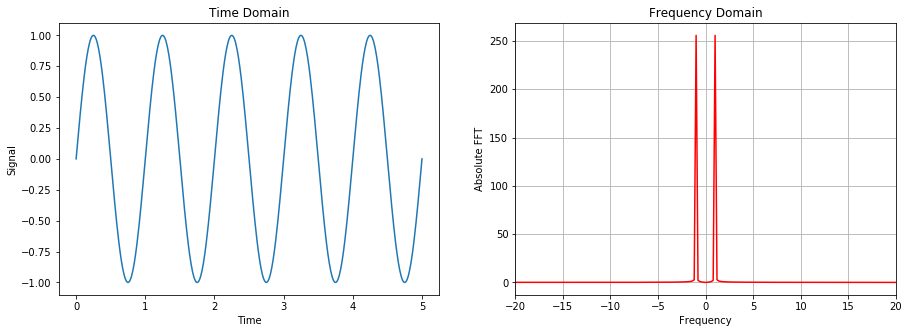

In [5]:
plot_time_freq(time, y_sine)

In this example we will change the frequency to 10Hz, and we observe that the peaks in the Frequency Domain are now located at the 10 Hz point.

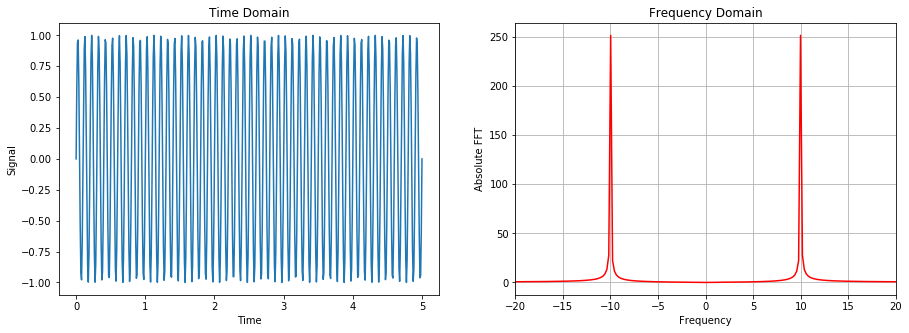

In [6]:
freq = 10

# Data set in Time Domain
y_sine = np.sin(2 * np.pi * freq * time)

plot_time_freq(time, y_sine)

Constant values are equivalent to having a frequency at 0 Hz.  The example below shows a constant at 1 in the time domain, which equates to a spike at 0Hz in the frequency domain.

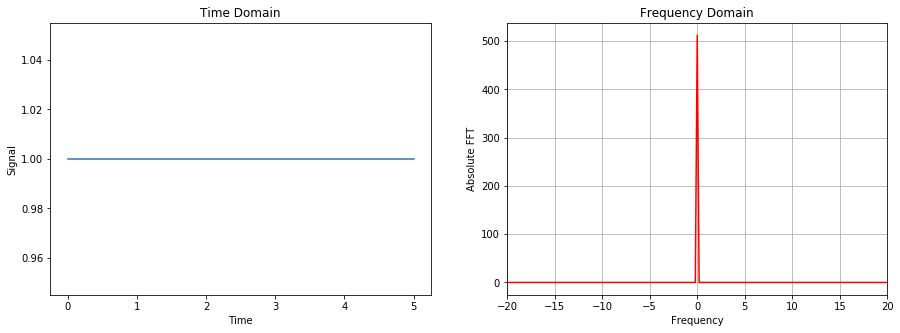

In [7]:
# Data set in Time Domain
y_constant = np.ones(time.shape)

plot_time_freq(time, y_constant)

### Problem 1

In the next example create a signal that contains 2 sine waves of different amplitudes at 1 and 10 Hz as well as a constant term.  Plot the time and frequency domain.

### Problem 2

In the next example, plot the time and frequency domain representation of Gaussian distrubuted random noise. Noise tends to contain all frequency components. 

### Signal with Trend and Noise
Next we will analyze a signal that contains:
* A sine wave representing seasonality
* a parabolic function representing a trend
* and uniformly distributed random noise

Below we create and plot each of the components separately.

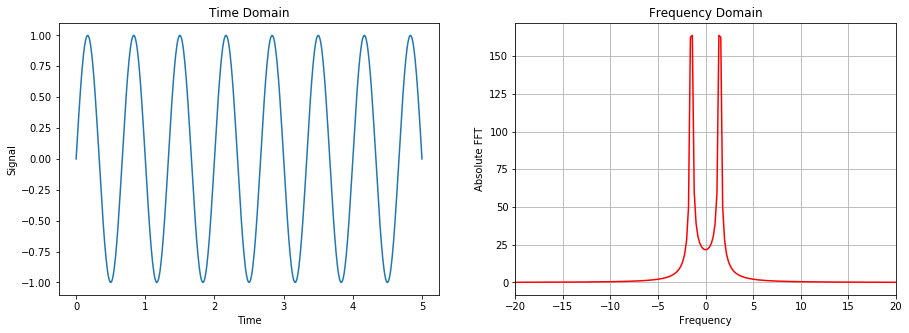

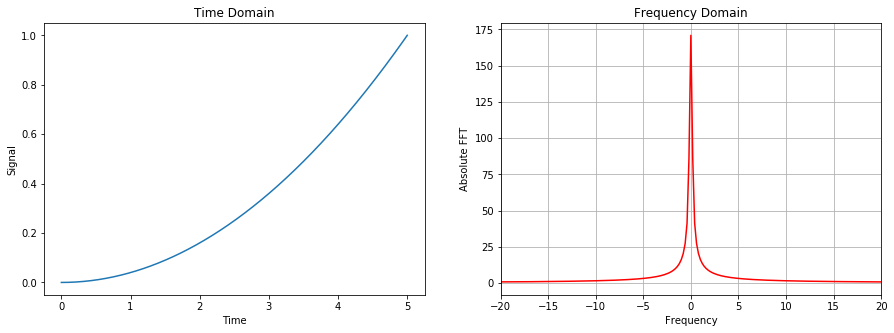

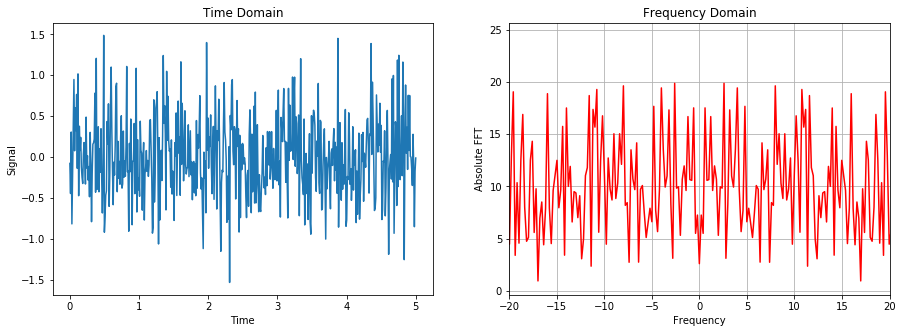

In [8]:
freq = 1.5

# Data set in Time Domain
y_sine = np.sin(2 * np.pi * freq * time)
y_trend = (0.2 * time)**2
y_noise = 0.5 * np.random.randn(len(time))

plot_time_freq(time, y_sine)
plot_time_freq(time, y_trend)
plot_time_freq(time, y_noise)

We can observe that in the Frequency Domain: 
1. The sine wave has components at -1.5 and +1.5. 
2. The trend has low frequency components (close to 0). 
3. The noise has components across all frequencies.

### Problem 3

Add the three signals together but provide an amplitude of 3, 2, and 1 to the sine, trend, and noise, respectively. Observe the time and frequency domain components.
> Feel free to repeat the process and play with different coefficient values. 

In [9]:
y_sine_noise = #fill in here

plot_time_freq(time, y_sine_noise)

SyntaxError: invalid syntax (<ipython-input-9-4946397101b6>, line 1)

# Section 2: Filters 
Removing noise is a well-known preprocessing technique for extracting patterns in your data.

## Low Pass Filters

Let's say we want to get rid of the noise. One option for doing this is to apply a low-pass filter which removes the high frequency components and allows the low frequency components to pass through.

Examples of low pass filters include: the Hann Window, Tukey Filter and Butterworth Filter.  

### Hann Window

The Hann window, is named after Julius von Hann, and is sometimes referred to as Hanning or as a raised cosine.  The shape of the filter in time domain is one lobe of an elevated cosine function. On the interval $ n\in [0,N-1]$ the Hann window function is:

$w(n)=0.5\;\left[1-\cos \left({\frac {2\pi n}{N-1}}\right)\right]=\sin ^{2}\left({\frac {\pi n}{N-1}}\right)$

### Tukey Filter

The Tukey window, also known as the tapered cosine window, can be regarded as a cosine lobe of width $αN/2$ that is convolved with a rectangular window of width $(1 − α/2)N$.  The expression of the filter in time domain is given by:

$ w(n)=\left\{{\begin{matrix}{\frac {1}{2}}\left[1+\cos \left(\pi \left({\frac {2n}{\alpha (N-1)}}-1\right)\right)\right]&0\leqslant n<{\frac {\alpha (N-1)}{2}}\\1&{\frac {\alpha (N-1)}{2}}\leqslant n\leqslant (N-1)(1-{\frac {\alpha }{2}})\\{\frac {1}{2}}\left[1+\cos \left(\pi \left({\frac {2n}{\alpha (N-1)}}-{\frac {2}{\alpha }}+1\right)\right)\right]&(N-1)(1-{\frac {\alpha }{2}})<n\leqslant (N-1)\\\end{matrix}}\right)$

At α = 0 it becomes rectangular, and at α = 1 it becomes a Hann window.

Let's run an example with the Tukey filter.  We have two parameters that we can tweak: alpha and the div_factor.  We can observe in the frequency domain that the shape of the filter is close to zero at high frequencies.  The goal is to mutiply the frequency domain signal of the filter with the frequency domain signal of the original signal.  The output should have a reduction of signal at the high frequency components.

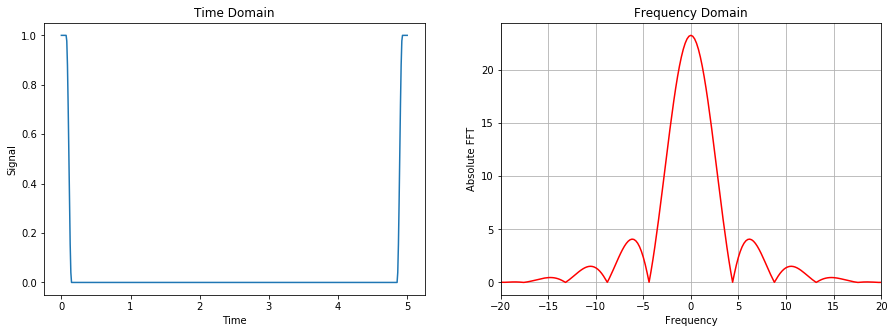

In [10]:
# parameters
alpha = 0.5
div_factor = 16 # use multiple of 2 (e.g. 2, 4, 8, 16, etc.)

# buid filter
win_temp = signal.tukey(int( len(time) / div_factor ), alpha=alpha)
window = np.zeros(time.shape)
window[:int(len(win_temp)/2)] = win_temp[int(len(win_temp)/2):]
window[(int(len(window)) - int(len(win_temp)/2)):] = win_temp[:int(len(win_temp)/2)]

#plot
plot_time_freq(time, window)

We'll apply the filter on the original signal but first let's create a function to print the results.

In [11]:
def filter_plot(time, y_original, y_filtered, legend_names):
    plt.figure(figsize=[15,10])
    plt.plot(time, y_original, 'k', lw=1)
    plt.plot(time, np.real(y_filtered), 'r', lw=3)
    plt.legend(legend_names);

In [12]:
# setup 
win = (np.fft.fft(window))
win = win/win.max()

# apply filter
Y = (np.fft.fft(y_sine_noise))
y_tukey = np.fft.ifft(Y*win)

# plot
filter_plot(time, y_sine_noise, y_tukey, ['Signal+Trend+Noise','Signal+Trend','Fitered Tukey Signal'])

NameError: name 'y_sine_noise' is not defined

We can observe that the "Filtered Signal" matches very closely the "Signal + Trend", and most of the noise has been removed.  

### Problem 4

Modify the values of "alpha" and "div_factor" to optimize the filter.

### Butterworth Filter

Another commonly used low pass filter is the Butterworth filter. 

Here we will design a Butterworth filter and then filter our original signal.

In [13]:
# First, design the Butterworth filter
N  = 2    # Filter order
Wn = 0.05 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
y_low_butter = signal.filtfilt(B,A, y_sine_noise)

# plot
filter_plot(time, y_sine_noise, y_low_butter, ['Signal+Trend+Noise','Signal+Trend','Fitered Low Butterworth Signal'])

NameError: name 'y_sine_noise' is not defined

Here we observe again the filtered signal resembling the original signal without the noise. 

### Problem 5

Modify the filter order and cutoff frequency.

### High Pass Filter

Similarly, as we were able to filter out the high frequency components which got rid of most of the noise, we can filter out the low frequency components and get rid of the trend.  Next, we will use a Butterworth filter in a high pass filter configuration.

In [16]:
# First, design the Buterworth filter
N  = 2    # Filter order
Wn = 0.02 # Cutoff frequency
B, A = signal.butter(N, Wn, btype = 'highpass',output='ba')
 
# Second, apply the filter
y_high_butter = signal.filtfilt(B, A, y_sine_noise)

# plot
filter_plot(time, y_sine_noise, y_high_butter, ['Signal+Trend+Noise','Signal+Trend','Fitered High Butterworth Signal'])

NameError: name 'y_sine_noise' is not defined

We can observe that the trend has been removed.

### Problem 6

Modify the filter order and cutoff frequency.

### Band Pass Filter
We can also combine both a high pass and low pass filter to be able to remove the high and low frequency components of a signal.  This is known as a band pass filter.  Here, we will also use a Butterworth filter.

In [ ]:
# First, design the Buterworth filter
N  = 2    # Filter order
Wn = [0.02,0.05] # Cutoff frequency
B, A = signal.butter(N, Wn, btype = 'bandpass',output='ba')
 
# Second, apply the filter
y_band_butter = signal.filtfilt(B,A, y_sine_noise)

# plot
filter_plot(time, y_sine_noise, y_band_butter, 
            ['Signal+Trend+Noise','Signal+Trend', 'Original Sine Wave','Fitered Band Butterworth Signal'])

We observe that the original signal has been de-trended, and the noise has been removed.  We were able to extract the original signal.  Several parameters can be optimized to improve this filter.  

Fourier Transforms are useful because they can:
1. Remove trend. 
2. Remove noise. 
3. Convert a nonstationary time series signal into a stationary one.

### Problem 7

Modify the filter order and cutoff frequency.

# Making Forecasts with Fourier Transforms

In [ ]:
def fourierPrediction(y, n_predict):
    n = y.size
    n_harm = 5                         # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, y, 1)            # find linear trend in x
    y_notrend = y - p[0] * t           # detrended x
    y_freqdom = np.fft.fft(y_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(y_freqdom[i]) / n   # amplitude
        phase = np.angle(y_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [ ]:
def fourierPredictionPlot(y, prediction):
    plt.plot(np.arange(0, y.size), y, 'b', label = 'data', linewidth = 2)
    plt.plot(np.arange(0, prediction.size), prediction, 'r', label = 'prediction')
    plt.legend();

#### Example 1: Prediction on y_sine_noise

In [17]:
# setup
n_predict = 300
prediction = fourierPrediction(y_sine_noise, n_predict)

# plot
fourierPredictionPlot(y_sine_noise, prediction)

NameError: name 'fourierPrediction' is not defined

#### Get CO2 Data

In [18]:
# load the dataset
df = pd.read_csv('co2-ppm-mauna-loa-19651980.csv', usecols=[1], engine='python', skipfooter=3)
data = np.reshape( df.values.astype('float32'), len(df) )
print('Number of data points:', df.count()[0])

Number of data points: 192


#### Plot Time Domain & Frequency Domain

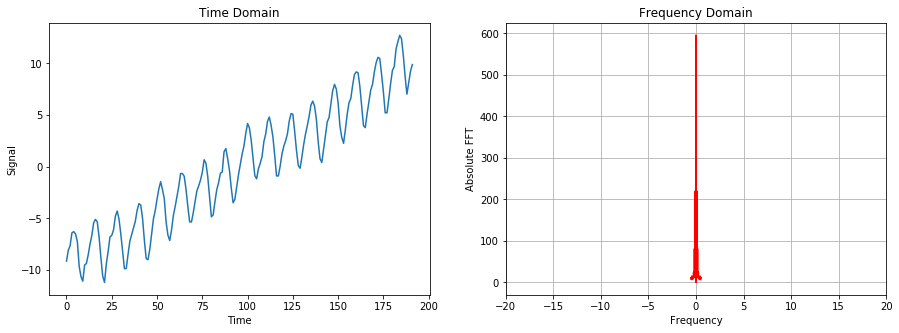

In [19]:
t = np.arange(len(data))
plot_time_freq(t, data-data.mean())

#### Example 2: Predictions on CO2 Data

In [20]:
# setup
n_predict = 50
prediction = fourierPrediction(data, n_predict)

# plot
fourierPredictionPlot(data, prediction)

NameError: name 'fourierPrediction' is not defined

---

# Summary

In this assignment you should have gained: 
1. A basic understanding of the Fourier Transform (FT).
2. Knowledge of the most common filters and why they are useful.
3. The know-how to make forecasts using the Fourier Transform.

Congratulations, that concludes this lesson.

In [ ]:
print('end')